# Programming for Data Science Project
# Flight Data Analyses and Flight Delays Prediction
# © 2022 YUI CHEE XUAN

### Importing Required Packages

##### Basic Packages

In [1]:
import pandas as pd
import numpy as np

##### For SQLite Database

In [2]:
import sqlite3
import os

##### For Data Visualisations

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_style('whitegrid')
sns.reset_defaults()
%matplotlib inline

##### For Network Visualisation in Question 4

In [4]:
import networkx as nx

##### For Machine Learning in Question 5

In [5]:
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV      
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer #transform different types
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier  
from sklearn.gaussian_process import GaussianProcessClassifier  
from sklearn.gaussian_process.kernels import RBF 
from sklearn.svm import LinearSVC  

### Creating Database using SQLite

In [6]:
# Remove the previous db files to ensure can run this notebook multiple times without errors
try:
    os.remove('../ST2195_Coursework/flight_python.db')
except OSError:
    pass

In [7]:
# create database
conn = sqlite3.connect('flight_python.db')

In [8]:
# first create the table for delays, which requires 3 csv files
c = conn.cursor()

c.execute('''
CREATE TABLE delays (
  Year int,
  Month int,
  DayofMonth int,
  DayOfWeek int,
  DepTime  int,
  CRSDepTime int,
  ArrTime int,
  CRSArrTime int,
  UniqueCarrier varchar(5),
  FlightNum int,
  TailNum varchar(8),
  ActualElapsedTime int,
  CRSElapsedTime int,
  AirTime int,
  ArrDelay int,
  DepDelay int,
  Origin varchar(3),
  Dest varchar(3),
  Distance int,
  TaxiIn int,
  TaxiOut int,
  Cancelled int,
  CancellationCode varchar(1),
  Diverted varchar(1),
  CarrierDelay int,
  WeatherDelay int,
  NASDelay int,
  SecurityDelay int,
  LateAircraftDelay int
)
''')

conn.commit()

### Loading Datasets

In [10]:
# A way to read bz2 files for 2004,2005,2006 directly in Python using "compression" and write to sqlite
for year in range(2004, 2007):
    print('Processing: ', year)
    delays = pd.read_csv(str(year)+".csv.bz2", compression='bz2')  
    delays.to_sql('delays', con = conn, if_exists = 'append', index = False)

conn.commit()

Processing:  2004
Processing:  2005
Processing:  2006


In [11]:
# Create tables
# next create the tables for the airports, carrier and planes dataset
airports = pd.read_csv("airports.csv")
carriers = pd.read_csv("carriers.csv")
planes = pd.read_csv("plane-data.csv")

# index = False to ensure the DataFrame row index is not written into the SQL tables
airports.to_sql('airports', con = conn, index = False)
carriers.to_sql('carriers', con = conn, index = False)
planes.to_sql('planes', con = conn, index = False)

5029

### Previewing Tables in Database

In [12]:
c.execute("SELECT name FROM sqlite_master WHERE type='table'").fetchall()

[('delays',), ('airports',), ('carriers',), ('planes',)]

# Exploratory Data Analysis (EDA) on Question 1 to 4
# Q1. When is the best time of day, day of the week, and time of year to fly to minimise delays? 
To be logical, the following are the best time to fly to minimise delay based on time of the day, day of the week, day of the month and the best month respectively.

To start off this question 1, I first extracted the data that was required to answer this question from the database that I have created previously through `c.execute().fetchall()` and saved in a data frame called `delays_df`. 

I used the SQL commands in `c.execute()` to `SELECT` the columns from the database which are `Year`, `Month`, `DayofMonth`, `DayOfWeek`, `DepTime` (Departure Time) and `ArrDelay` (Arrival Delay) `FROM` the `delays` table in the database connection.

As the question is asking pertaining to minimise delay, I filtered the data with only the arrival delays while extracting the data using `WHERE` SQL command where arrival delay is > 0. Arrival delay less than and equal to 0 is considered not delay. This sense holds for the following questions too.

One of the important points is why do we use arrival delay and not the departure delay? Here is my assumption, I assume that flight customers are most likely to merely care about whether they are going to arrive at their destination on time.

In [12]:
# Extract data from database and saved as data frame
delays_df = c.execute('''
SELECT Year,Month,DayofMonth,DayOfWeek,DepTime,ArrDelay 
FROM delays
WHERE delays.ArrDelay > 0
''').fetchall()

delays_df = pd.DataFrame(delays_df)
delays_df

,0,1,2,3,4,5
0,2004,1,14,3,633,5
1,2004,1,16,5,635,3
2,2004,1,19,1,650,29
3,2004,1,23,5,631,8
4,2004,1,27,2,625,24
...,...,...,...,...,...,...
9279025,2006,12,29,5,1803,4
9279026,2006,12,29,5,1314,27
9279027,2006,12,29,5,1151,7
9279028,2006,12,29,5,1225,62


In [11]:
delays_df.rename({0:"Year",1:"Month",2:"DayofMonth",
                  3:"DayOfWeek",4:"DepTime",5:"ArrDelay"},
                 axis=1, inplace=True) # axis=1 is to denote columns to be renamed.
delays_df.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,ArrDelay
0,2004,1,14,3,633,5
1,2004,1,16,5,635,3
2,2004,1,19,1,650,29
3,2004,1,23,5,631,8
4,2004,1,27,2,625,24


In [12]:
delays_df.shape

(9279030, 6)

In [13]:
delays_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9279030 entries, 0 to 9279029
Data columns (total 6 columns):
 #   Column      Dtype
---  ------      -----
 0   Year        int64
 1   Month       int64
 2   DayofMonth  int64
 3   DayOfWeek   int64
 4   DepTime     int64
 5   ArrDelay    int64
dtypes: int64(6)
memory usage: 424.8 MB


In [155]:
# Select the row with departure time from 0000 hours to 2359 hours
best_time_of_day = delays_df.groupby(['DepTime']).mean()[['ArrDelay']].loc[0:2359]
best_time_of_day.rename(columns={"ArrDelay":"Avg_ArrDelay"}, inplace=True)
best_time_of_day.sort_values(by=['Avg_ArrDelay'], inplace=True)
best_time_of_day.head()

,Avg_ArrDelay
DepTime,
507,6.881356
523,8.192878
514,8.271186
532,8.570248
457,8.671329


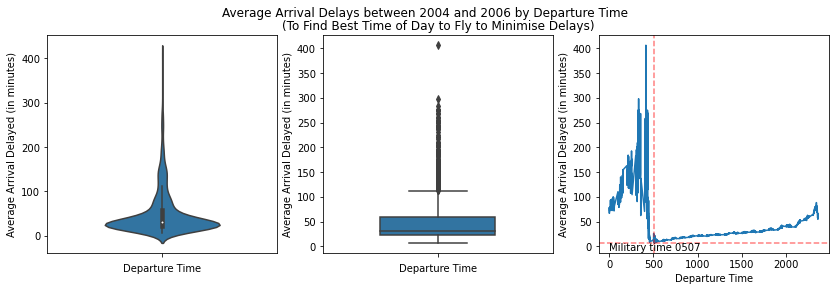

In [188]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4))

#Graphs are created and lineplot is stored in a variable 'line'
sns.violinplot(data = best_time_of_day, y = 'Avg_ArrDelay', ax = ax[0], width = 0.5)
sns.boxplot(data = best_time_of_day, y = 'Avg_ArrDelay', ax = ax[1], width = 0.5)
line = sns.lineplot(data = best_time_of_day, x = 'DepTime', y = 'Avg_ArrDelay', ax = ax[2])

# Drawing a horizontal and vertical line at lowest point of average arrival delay      
line.axhline(best_time_of_day.iloc[0,0], color = 'r', linestyle = '--', alpha = 0.5)
line.axvline(best_time_of_day.first_valid_index(), color = 'r', linestyle = '--', alpha = 0.5)
# Labelling the correspond departure time that has the lowest average arrival delay
line.text(0.5, -9, "Military time 0" + str(best_time_of_day.first_valid_index()))

ax[0].set_xlabel("Departure Time")
ax[1].set_xlabel("Departure Time")
ax[2].set_xlabel("Departure Time")

ax[0].set_ylabel("Average Arrival Delayed (in minutes)")
ax[1].set_ylabel("Average Arrival Delayed (in minutes)")
ax[2].set_ylabel("Average Arrival Delayed (in minutes)")

ax[1].title.set_text("(To Find Best Time of Day to Fly to Minimise Delays)")
fig.suptitle('Average Arrival Delays between 2004 and 2006 by Departure Time')

plt.savefig('best_time_of_day.png') # you can find the file in the folder where you run this line of code

In [167]:
best_day_of_week = delays_df.groupby(['DayOfWeek']).mean()[['ArrDelay']]
best_day_of_week.sort_values(by=['ArrDelay'], inplace=True)
best_day_of_week.head(3)
#best_day_of_week.plot.bar()

,ArrDelay
DayOfWeek,
6,25.811750
2,27.091353
7,28.735173


In [168]:
best_day_of_month = delays_df.groupby(['DayofMonth']).mean()[['ArrDelay']]
best_day_of_month.sort_values(by=['ArrDelay'], inplace=True)
best_day_of_month.head(3)
#best_day_of_month.plot.bar()

,ArrDelay
DayofMonth,
8,25.810653
3,26.420969
6,26.767002


In [169]:
best_month = delays_df.groupby(['Month']).mean()[['ArrDelay']]
best_month.sort_values(by=['ArrDelay'], inplace=True)
best_month.head(3)
#best_month.plot.bar()

,ArrDelay
Month,
4,24.349793
9,26.109145
10,26.532404


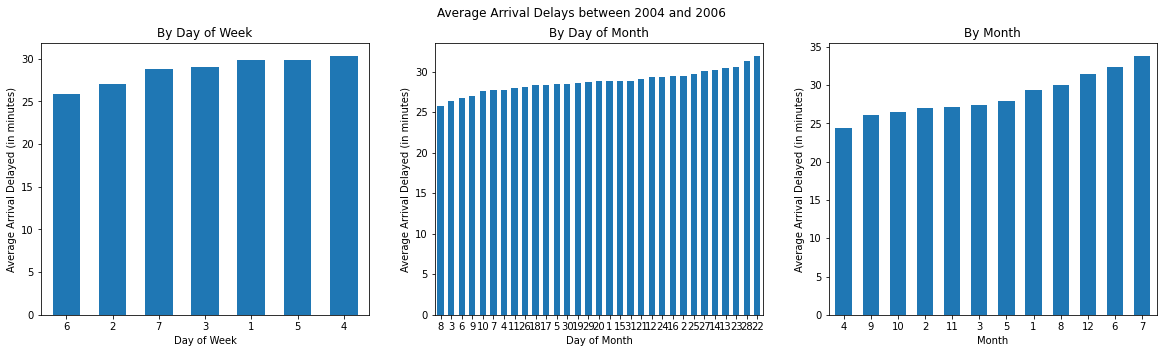

In [184]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5)) # ax is an array of an array (1x3)

fig.suptitle('Average Arrival Delays between 2004 and 2006')

# ax = ax[0] indicates its the subplot on left
best_day_of_week['ArrDelay'].plot.bar(x = 'Day of Week', y = 'ArrDelay', rot = 0, ax = ax[0], 
                                      legend = False, width = 0.6) # legend = False: not to show legend
ax[0].set_xlabel("Day of Week")
ax[0].set_ylabel("Average Arrival Delayed (in minutes)")
ax[0].title.set_text("By Day of Week")

# ax = ax[1] indicates its the subplot on middle
best_day_of_month['ArrDelay'].plot.bar(x = 'Day of Month', y = 'ArrDelay', rot = 0, ax = ax[1], 
                                      legend = False, width = 0.6) # legend = False: not to show legend
ax[1].set_xlabel("Day of Month")
ax[1].set_ylabel("Average Arrival Delayed (in minutes)")
ax[1].title.set_text("By Day of Month")

# ax = ax[2] indicates its the subplot on right
best_month['ArrDelay'].plot.bar(x = 'Month', y = 'ArrDelay', rot = 0, ax = ax[2], 
                                      legend = False, width = 0.6) # legend = False: not to show legend
ax[2].set_xlabel("Month")
ax[2].set_ylabel("Average Arrival Delayed (in minutes)")
ax[2].title.set_text("By Month")

plt.savefig('best_day_month.png') # you can find the file in the folder where you run this line of code

# 2. Do older planes suffer more delays?
## Data Cleaning and Pre-processing
### Based on manufacture year for arrival delay

In [225]:
# Extract data from database and saved as data frame
delays_df2a = c.execute('''
SELECT tailnum, planes.model, planes.year, 
AVG(delays.ArrDelay) AS avg_arr_delay
FROM delays INNER JOIN planes USING(tailnum)
WHERE delays.ArrDelay > 0
GROUP BY planes.year
ORDER BY planes.year
''').fetchall()

delays_df2a = pd.DataFrame(delays_df2a)
delays_df2a

,0,1,2,3
0,N802UA,None,None,32.126788
1,N235SW,EMB-120ER,0000,22.270383
2,N381AA,DC-7BF,1956,30.850144
3,N3744D,182A,1957,21.247430
4,N201AA,150,1959,33.001278
5,N421AA,421C,1962,32.848358
6,N378AA,172E,1963,32.278814
7,N550AA,HST-550,1964,32.139166
8,N14629,737-524,1965,35.140972
9,N972CA,PA-28-180,1966,29.953063


In [244]:
delays_df2a.rename({0:"tailnum",1:"planes_model",2:"planes_year",3:"avg_arr_delay"},
                   axis=1, inplace=True) # axis=1 is to denote columns to be renamed.
print(delays_df2a.head())
print(delays_df2a.shape)
delays_df2a.info()

  tailnum planes_model planes_year  avg_arr_delay
1  N235SW    EMB-120ER        0000      22.270383
2  N381AA       DC-7BF        1956      30.850144
3  N3744D         182A        1957      21.247430
4  N201AA          150        1959      33.001278
5  N421AA         421C        1962      32.848358
(49, 4)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 49 entries, 1 to 49
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   tailnum        49 non-null     object 
 1   planes_model   49 non-null     object 
 2   planes_year    49 non-null     object 
 3   avg_arr_delay  49 non-null     float64
dtypes: float64(1), object(3)
memory usage: 1.9+ KB


I combine 'dropna' with 'mask' and ensure that the entire dataframe is object when I compare with.

In [242]:
# eq()="equal to operation" 
# drop two rows with missing values
delays_df2a = delays_df2a.mask(delays_df2a.astype(object).eq('None')).dropna()
print(delays_df2a.shape)
delays_df2a.info()

(49, 4)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 49 entries, 1 to 49
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   tailnum        49 non-null     object 
 1   planes_model   49 non-null     object 
 2   planes_year    49 non-null     object 
 3   avg_arr_delay  49 non-null     float64
dtypes: float64(1), object(3)
memory usage: 1.9+ KB


### Based on manufacture year for departure delay

In [243]:
# Extract data from database and saved as data frame
delays_df2b = c.execute('''
SELECT tailnum, planes.model, planes.year, 
AVG(delays.DepDelay) AS avg_dep_delay
FROM delays INNER JOIN planes USING(tailnum)
WHERE delays.DepDelay > 0
GROUP BY planes.year
ORDER BY planes.year
''').fetchall()

delays_df2b = pd.DataFrame(delays_df2b)
delays_df2b

,0,1,2,3
0,N802UA,None,None,32.633584
1,N235SW,EMB-120ER,0000,25.545953
2,N381AA,DC-7BF,1956,30.006472
3,N3744D,182A,1957,18.753012
4,N567AA,OTTER DHC-3,1959,33.110852
5,N421AA,421C,1962,33.002182
6,N378AA,172E,1963,33.284718
7,N550AA,HST-550,1964,33.395694
8,N14629,737-524,1965,38.032939
9,N972CA,PA-28-180,1966,36.664071


In [245]:
delays_df2b.rename({0:"tailnum",1:"planes_model",2:"planes_year",3:"avg_dep_delay"},
                   axis=1, inplace=True) # axis=1 is to denote columns to be renamed.
print(delays_df2b.head())
print(delays_df2b.shape)
delays_df2b.info()

  tailnum planes_model planes_year  avg_dep_delay
0  N802UA         None        None      32.633584
1  N235SW    EMB-120ER        0000      25.545953
2  N381AA       DC-7BF        1956      30.006472
3  N3744D         182A        1957      18.753012
4  N567AA  OTTER DHC-3        1959      33.110852
(51, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   tailnum        51 non-null     object 
 1   planes_model   50 non-null     object 
 2   planes_year    50 non-null     object 
 3   avg_dep_delay  51 non-null     float64
dtypes: float64(1), object(3)
memory usage: 1.7+ KB


In [246]:
# eq()="equal to operation" 
# drop two rows with missing values
delays_df2b = delays_df2b.mask(delays_df2b.astype(object).eq('None')).dropna()
print(delays_df2b.shape)
delays_df2b.info()

(49, 4)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 49 entries, 1 to 49
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   tailnum        49 non-null     object 
 1   planes_model   49 non-null     object 
 2   planes_year    49 non-null     object 
 3   avg_dep_delay  49 non-null     float64
dtypes: float64(1), object(3)
memory usage: 1.9+ KB


In [258]:
delays_df2 = delays_df2a.merge(delays_df2b, on = "planes_year")[['planes_year','avg_arr_delay','avg_dep_delay']]

# Drop first row with plane's year 0000
# by selecting all rows from second row onwards (index starts with 0)
delays_df2 = delays_df2.iloc[1: , :]

delays_df2.head()

,planes_year,avg_arr_delay,avg_dep_delay
1,1956,30.850144,30.006472
2,1957,21.247430,18.753012
3,1959,33.001278,33.110852
4,1962,32.848358,33.002182
5,1963,32.278814,33.284718


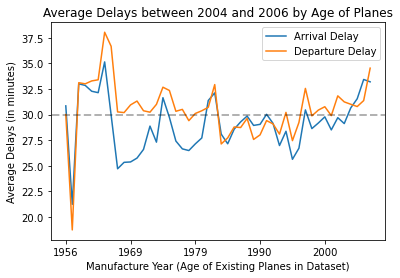

In [283]:
fig, ax = plt.subplots()

delays_df2.plot(x = 'planes_year', y = 'avg_arr_delay', ax = ax) 
delays_df2.plot(x = 'planes_year', y = 'avg_dep_delay', ax = ax)

ax.legend(["Arrival Delay", "Departure Delay"])

ax.set_xlabel('Manufacture Year (Age of Existing Planes in Dataset)')
ax.set_ylabel('Average Delays (in minutes)')

ax.title.set_text("Average Delays between 2004 and 2006 by Age of Planes")

# Add a horizontal partition line
ax.axhline(y=30, xmin=-1, xmax=1, color='k', linestyle='--', lw=2, alpha=0.3)

plt.savefig('Q2a.png') # you can find the file in the folder where you run this line of code

# Q3. How does the number of flights flying between different locations change over time?

### Data Extraction and Pre-processing

In [14]:
# Extract data for Q3 from database and saved as data frame
# !Required some time to extract! Once extracted this, the following code chunks of this question should be run quite fast
df3 = c.execute('''
SELECT delays.Year,delays.Month,OriAirport.city,DestAirport.city
FROM delays
INNER JOIN airports as OriAirport ON delays.Origin=OriAirport.iata
INNER JOIN airports as DestAirport ON delays.Dest=DestAirport.iata
WHERE Cancelled=0 AND Diverted=0
''').fetchall() 

df3 = pd.DataFrame(df3)
df3

,0,1,2,3
0,2004,1,Chicago,Charlotte
1,2004,1,Chicago,Charlotte
2,2004,1,Chicago,Charlotte
3,2004,1,Chicago,Charlotte
4,2004,1,Chicago,Charlotte
...,...,...,...,...
20984363,2006,12,Atlanta,Newark
20984364,2006,12,Seattle,Atlanta
20984365,2006,12,Atlanta,Orlando
20984366,2006,12,Salt Lake City,San Jose


`axis=1` is to denote columns to be renamed.

In [15]:
df3.rename({0:"Year",1:"Month",2:"Origin_City",3:"Dest_City"}, axis=1, inplace=True)
df3.head()

,Year,Month,Origin_City,Dest_City
0,2004,1,Chicago,Charlotte
1,2004,1,Chicago,Charlotte
2,2004,1,Chicago,Charlotte
3,2004,1,Chicago,Charlotte
4,2004,1,Chicago,Charlotte


One city can have many airports

### Data Manipulation and Preparation

Below, I apply the Pandas series `strftime()` method to the `DatePretend` datetime column to convert values to the string format of %Y-%m.

In [16]:
df3['DatePretend'] = pd.to_datetime(df3[['Year', 'Month']].assign(DAY=1))
df3['Year_Month'] = df3['DatePretend'].dt.strftime('%Y-%m')
df3['Flying_between_different_cities'] = df3.Origin_City + " -> " + df3.Dest_City
df3

,Year,Month,Origin_City,Dest_City,DatePretend,Year_Month,Flying_between_different_cities
0,2004,1,Chicago,Charlotte,2004-01-01,2004-01,Chicago -> Charlotte
1,2004,1,Chicago,Charlotte,2004-01-01,2004-01,Chicago -> Charlotte
2,2004,1,Chicago,Charlotte,2004-01-01,2004-01,Chicago -> Charlotte
3,2004,1,Chicago,Charlotte,2004-01-01,2004-01,Chicago -> Charlotte
4,2004,1,Chicago,Charlotte,2004-01-01,2004-01,Chicago -> Charlotte
...,...,...,...,...,...,...,...
20984363,2006,12,Atlanta,Newark,2006-12-01,2006-12,Atlanta -> Newark
20984364,2006,12,Seattle,Atlanta,2006-12-01,2006-12,Seattle -> Atlanta
20984365,2006,12,Atlanta,Orlando,2006-12-01,2006-12,Atlanta -> Orlando
20984366,2006,12,Salt Lake City,San Jose,2006-12-01,2006-12,Salt Lake City -> San Jose


In [17]:
# function for only applicable for df3
def flight_numbers_fly_betw_cities_over_time(xvar,location):
    newdf = df3.groupby([xvar,location])[['Year']].count() 
    newdf.columns = ['Total_Number_of_Flights']
    newdf.sort_values(by=['Total_Number_of_Flights'], ascending=False, inplace=True)
    newdf = newdf.reset_index()
    return newdf

In [18]:
# self randomly select the countries in the analysis
countries = ["New York -> Boston","Los Angeles -> San Diego",
             "Dallas-Fort Worth -> Chicago","Chicago -> Minneapolis",
             "San Francisco -> Los Angeles","Phoenix -> Denver"]

### Data Preparation for Year Variable

In [19]:
byYear = flight_numbers_fly_betw_cities_over_time("Year","Flying_between_different_cities")
byYear

,Year,Flying_between_different_cities,Total_Number_of_Flights
0,2006,New York -> Boston,20346
1,2006,Boston -> New York,20309
2,2005,Boston -> New York,17459
3,2005,New York -> Boston,17400
4,2004,Boston -> New York,16863
...,...,...,...
12611,2005,Jacksonville -> Valdosta,1
12612,2005,Jacksonville -> Los Angeles,1
12613,2005,Yuma -> Phoenix,1
12614,2004,San Diego -> Yuma,1


In [20]:
byYear_reducedrows = byYear[byYear.Flying_between_different_cities.isin(countries)]
byYear_reducedrows

,Year,Flying_between_different_cities,Total_Number_of_Flights
0,2006,New York -> Boston,20346
3,2005,New York -> Boston,17400
5,2004,New York -> Boston,16479
6,2004,Chicago -> Minneapolis,15827
8,2005,Los Angeles -> San Diego,15007
14,2004,Los Angeles -> San Diego,14340
19,2005,Chicago -> Minneapolis,14287
20,2006,Los Angeles -> San Diego,14280
29,2006,Chicago -> Minneapolis,13743
50,2004,Dallas-Fort Worth -> Chicago,12261


In [21]:
table_byYear = byYear_reducedrows.pivot(index='Year', columns='Flying_between_different_cities', 
                                     values='Total_Number_of_Flights')
table_byYear

Flying_between_different_cities,Chicago -> Minneapolis,Dallas-Fort Worth -> Chicago,Los Angeles -> San Diego,New York -> Boston,Phoenix -> Denver,San Francisco -> Los Angeles
Year,,,,,,
2004,15827,12261,14340,16479,4965,9036
2005,14287,11700,15007,17400,6615,8369
2006,13743,11686,14280,20346,10395,9746


### Data Preparation for Year Month Variable

In [22]:
byYearMonth = flight_numbers_fly_betw_cities_over_time('Year_Month','Flying_between_different_cities')
byYearMonth

,Year_Month,Flying_between_different_cities,Total_Number_of_Flights
0,2006-10,New York -> Boston,1862
1,2006-10,Boston -> New York,1858
2,2006-08,Boston -> New York,1788
3,2006-08,New York -> Boston,1783
4,2006-03,New York -> Boston,1763
...,...,...,...
134521,2006-01,Greensboro -> Memphis,1
134522,2004-12,Pasco -> Spokane,1
134523,2006-04,San Francisco -> Eagle,1
134524,2006-01,Harrisburg -> Philadelphia,1


In [23]:
byYearMonth_reducedrows = byYearMonth[byYearMonth.Flying_between_different_cities.isin(countries)]
byYearMonth_reducedrows

,Year_Month,Flying_between_different_cities,Total_Number_of_Flights
0,2006-10,New York -> Boston,1862
3,2006-08,New York -> Boston,1783
4,2006-03,New York -> Boston,1763
6,2006-11,New York -> Boston,1732
9,2006-09,New York -> Boston,1705
...,...,...,...
10345,2005-02,Phoenix -> Denver,383
10580,2004-07,Phoenix -> Denver,378
10643,2004-09,Phoenix -> Denver,377
10899,2004-06,Phoenix -> Denver,372


In [24]:
table_byYearMonth = byYearMonth_reducedrows.pivot(index='Year_Month', columns='Flying_between_different_cities', 
                                     values='Total_Number_of_Flights')
table_byYearMonth

Flying_between_different_cities,Chicago -> Minneapolis,Dallas-Fort Worth -> Chicago,Los Angeles -> San Diego,New York -> Boston,Phoenix -> Denver,San Francisco -> Los Angeles
Year_Month,,,,,,
2004-01,1295,1061,1330,1276,446,751
2004-02,1286,1025,1109,1295,442,698
2004-03,1357,1080,1174,1388,463,747
2004-04,1356,1076,1188,1408,415,719
2004-05,1295,1087,1241,1377,425,731
2004-06,1357,1007,1107,1408,372,749
2004-07,1352,1003,1156,1382,378,782
2004-08,1451,1009,1222,1421,387,792
2004-09,1328,959,1196,1372,377,760


### Data Visualisation for Q3

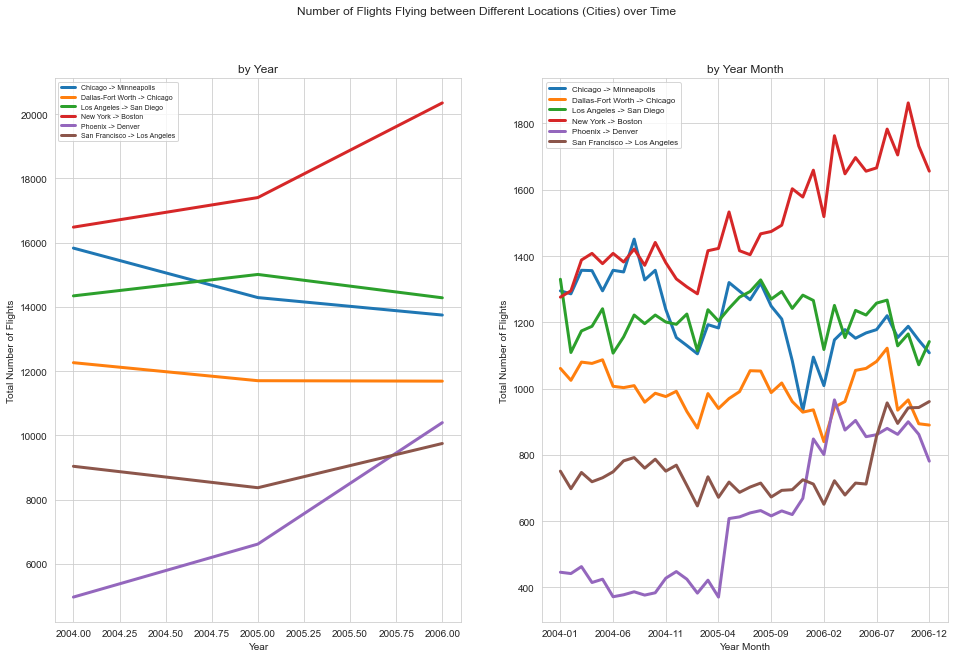

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

# ======== by Year ========
table_byYear.plot(kind='line', linewidth=3.0,figsize=(16,10),ax = ax[0]).legend(loc='upper left',fontsize = 7)
# Add title and axis names
ax[0].set_xlabel("Year")
ax[0].set_ylabel("Total Number of Flights")
ax[0].title.set_text("by Year")

# ======== by Year Month========
table_byYearMonth.plot(kind='line', linewidth=3.0,figsize=(16,10),ax = ax[1]).legend(loc='upper left',fontsize = 8)
# Add title and axis names
ax[1].set_xlabel("Year Month")
ax[1].set_ylabel("Total Number of Flights")
ax[1].title.set_text("by Year Month")

plt.suptitle("Number of Flights Flying between Different Locations (Cities) over Time")

plt.savefig('Q3.png') # you can find the file in the folder where you run this line of code

# Q4. Can you detect cascading failures as delays in one airport create delays in others?

Here are my assumptions and initial thoughts for answering this question. 

I assume that cascading failures in airports are kind of delays in the airline industry comprising interconnected airports and flights, in which the failure (delay) of an airport can trigger the failure (delay) of other airports or flights.  

In [60]:
# Extract data from database and saved as data frame
delays_df4 = c.execute('''
SELECT Origin,Dest,OriAirport.airport,DestAirport.airport,
OriAirport.lat,OriAirport.long,DestAirport.lat,DestAirport.long,ArrDelay,DepDelay,
CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,DepTime,ArrTime,TailNum
FROM delays
INNER JOIN airports as OriAirport ON delays.Origin=OriAirport.iata
INNER JOIN airports as DestAirport ON delays.Dest=DestAirport.iata
WHERE delays.Year=2004 
AND delays.Month=1 
AND delays.DayofMonth=1  
AND ArrDelay > 0
''').fetchall() 

#AND LateAircraftDelay > 0
#AND DepDelay > 0 

delays_df4 = pd.DataFrame(delays_df4)
delays_df4

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,ORD,PDX,Chicago O'Hare International,Portland Intl,41.979595,-87.904464,45.588722,-122.597500,28,5,0,0,28,0,0,1510,1753,N844UA
1,SAT,DEN,San Antonio International,Denver Intl,29.533694,-98.469778,39.858408,-104.667002,1,7,0,0,0,0,0,1814,1920,N906UA
2,CLT,DEN,Charlotte/Douglas International,Denver Intl,35.214011,-80.943126,39.858408,-104.667002,3,-3,0,0,0,0,0,857,1038,N322UA
3,ORD,SNA,Chicago O'Hare International,John Wayne /Orange Co,41.979595,-87.904464,33.675659,-117.868223,18,14,14,0,4,0,0,2004,2230,N436UA
4,ORD,BWI,Chicago O'Hare International,Baltimore-Washington International,41.979595,-87.904464,39.175402,-76.668198,83,60,0,0,23,0,60,1910,2228,N571UA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,RSW,BOS,Southwest Florida International,Gen Edw L Logan Intl,26.536167,-81.755167,42.364348,-71.005179,97,101,0,0,0,0,97,1556,1850,N650DL
5956,TPA,BDL,Tampa International,Bradley International,27.975472,-82.533250,41.938874,-72.683228,7,-8,0,0,0,0,0,1947,2237,N6716C
5957,JFK,LAS,John F Kennedy Intl,McCarran International,40.639751,-73.778926,36.080361,-115.152333,22,-5,0,0,22,0,0,2110,7,N67171
5958,PBI,LGA,Palm Beach International,LaGuardia,26.683162,-80.095594,40.777243,-73.872609,8,-7,0,0,0,0,0,1828,2119,N684DA


In [61]:
delays_df4.rename({0:"Origin",1:"Dest",2:"Origin_Airport",3:"Dest_Airport",4:"Origin_lat",
                   5:"Origin_long",6:"Dest_lat",7:"Dest_long",8:"ArrDelay",9:"DepDelay",
                   10:"CarrierDelay",11:"WeatherDelay",12:"NASDelay",13:"SecurityDelay",
                   14:"LateAircraftDelay",15:"DepTime",16:"ArrTime",17:"TailNum"},
                   axis=1, inplace=True) # axis=1 is to denote columns to be renamed.
#delays_df4.sort_values(by=['TailNum','DepTime'], ascending=True, inplace=True)
delays_df4

,Origin,Dest,Origin_Airport,Dest_Airport,Origin_lat,Origin_long,Dest_lat,Dest_long,ArrDelay,DepDelay,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,DepTime,ArrTime,TailNum
0,ORD,PDX,Chicago O'Hare International,Portland Intl,41.979595,-87.904464,45.588722,-122.597500,28,5,0,0,28,0,0,1510,1753,N844UA
1,SAT,DEN,San Antonio International,Denver Intl,29.533694,-98.469778,39.858408,-104.667002,1,7,0,0,0,0,0,1814,1920,N906UA
2,CLT,DEN,Charlotte/Douglas International,Denver Intl,35.214011,-80.943126,39.858408,-104.667002,3,-3,0,0,0,0,0,857,1038,N322UA
3,ORD,SNA,Chicago O'Hare International,John Wayne /Orange Co,41.979595,-87.904464,33.675659,-117.868223,18,14,14,0,4,0,0,2004,2230,N436UA
4,ORD,BWI,Chicago O'Hare International,Baltimore-Washington International,41.979595,-87.904464,39.175402,-76.668198,83,60,0,0,23,0,60,1910,2228,N571UA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,RSW,BOS,Southwest Florida International,Gen Edw L Logan Intl,26.536167,-81.755167,42.364348,-71.005179,97,101,0,0,0,0,97,1556,1850,N650DL
5956,TPA,BDL,Tampa International,Bradley International,27.975472,-82.533250,41.938874,-72.683228,7,-8,0,0,0,0,0,1947,2237,N6716C
5957,JFK,LAS,John F Kennedy Intl,McCarran International,40.639751,-73.778926,36.080361,-115.152333,22,-5,0,0,22,0,0,2110,7,N67171
5958,PBI,LGA,Palm Beach International,LaGuardia,26.683162,-80.095594,40.777243,-73.872609,8,-7,0,0,0,0,0,1828,2119,N684DA


## Exploratory Data Analysis (EDA) and Data Preparation for Q4

In [62]:
# To identify the airport that has the most arrival delays
MostArrDelay = delays_df4.groupby(['Dest_Airport'])[['DepTime']].count()
MostArrDelay.columns = ['Value_counts'] # rename column name from DepTime to Value_counts
MostArrDelay.sort_values(by=['Value_counts'], ascending=False, inplace=True)
MostArrDelay.head()

,Value_counts
Dest_Airport,
Dallas-Fort Worth International,392
Chicago O'Hare International,309
San Francisco International,284
Los Angeles International,280
George Bush Intercontinental,219


In [63]:
pd.set_option('display.max_rows', 50)
Airport_mostArrDelay = delays_df4[delays_df4['Dest_Airport'].isin(['Dallas-Fort Worth International'])]
Airport_mostArrDelay.sort_values(by=['ArrTime'])

,Origin,Dest,Origin_Airport,Dest_Airport,Origin_lat,Origin_long,Dest_lat,Dest_long,ArrDelay,DepDelay,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,DepTime,ArrTime,TailNum
3180,LAS,DFW,McCarran International,Dallas-Fort Worth International,36.080361,-115.152333,32.895951,-97.0372,123,135,123,0,0,0,0,2010,27,N307AW
4390,MCO,DFW,Orlando International,Dallas-Fort Worth International,28.428889,-81.316028,32.895951,-97.0372,217,235,0,0,0,0,217,2307,42,N5TMAA
3251,PHX,DFW,Phoenix Sky Harbor International,Dallas-Fort Worth International,33.434167,-112.008056,32.895951,-97.0372,10,19,0,0,0,0,0,2149,46,N334AW
4203,SMF,DFW,Sacramento International,Dallas-Fort Worth International,38.695422,-121.590767,32.895951,-97.0372,7,13,0,0,0,0,0,33,531,N410AA
1760,OKC,DFW,Will Rogers World,Dallas-Fort Worth International,35.393088,-97.600734,32.895951,-97.0372,4,0,0,0,0,0,0,555,656,N455SW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4624,LAX,DFW,Los Angeles International,Dallas-Fort Worth International,33.942536,-118.408074,32.895951,-97.0372,54,64,19,0,0,0,35,1819,2301,N442AA
5567,SLC,DFW,Salt Lake City Intl,Dallas-Fort Worth International,40.788388,-111.977773,32.895951,-97.0372,5,2,0,0,0,0,0,2017,2341,N3760C
4626,LAX,DFW,Los Angeles International,Dallas-Fort Worth International,33.942536,-118.408074,32.895951,-97.0372,11,21,0,0,0,0,0,1911,2354,N530AA
4613,SJC,DFW,San Jose International,Dallas-Fort Worth International,37.361862,-121.929009,32.895951,-97.0372,17,31,3,0,0,0,14,1853,2356,N454AA


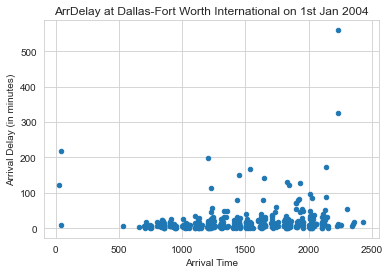

In [64]:
fig, ax = plt.subplots()

Airport_mostArrDelay.plot.scatter(x = 'ArrTime', y = 'ArrDelay', ax = ax) 

ax.set_xlabel('Arrival Time')
ax.set_ylabel('Arrival Delay (in minutes)')

ax.title.set_text("ArrDelay at Dallas-Fort Worth International on 1st Jan 2004")

plt.savefig('Q4a.png') # you can find the file in the folder where you run this line of code

In [65]:
Airport_mostArrDelay_LateAircraftDelay = Airport_mostArrDelay[Airport_mostArrDelay['LateAircraftDelay']>0]
Airport_mostArrDelay_LateAircraftDelay

,Origin,Dest,Origin_Airport,Dest_Airport,Origin_lat,Origin_long,Dest_lat,Dest_long,ArrDelay,DepDelay,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,DepTime,ArrTime,TailNum
244,ORD,DFW,Chicago O'Hare International,Dallas-Fort Worth International,41.979595,-87.904464,32.895951,-97.0372,30,28,0,0,6,0,24,1713,1947,N316UA
2922,SNA,DFW,John Wayne /Orange Co,Dallas-Fort Worth International,33.675659,-117.868223,32.895951,-97.0372,53,60,0,0,0,0,53,1500,1949,N709EV
3178,LAS,DFW,McCarran International,Dallas-Fort Worth International,36.080361,-115.152333,32.895951,-97.0372,24,11,10,0,13,0,1,1135,1616,N802AW
3458,XNA,DFW,Northwest Arkansas Regional,Dallas-Fort Worth International,36.281869,-94.306811,32.895951,-97.0372,28,33,0,0,0,0,28,1515,1627,N805MQ
3466,MEM,DFW,Memphis International,Dallas-Fort Worth International,35.042417,-89.976667,32.895951,-97.0372,18,12,0,0,6,0,12,1104,1243,N635MQ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5023,IAH,DFW,George Bush Intercontinental,Dallas-Fort Worth International,29.980472,-95.339722,32.895951,-97.0372,38,19,0,0,19,0,19,1859,2025,N18835
5600,SEA,DFW,Seattle-Tacoma Intl,Dallas-Fort Worth International,47.448982,-122.309313,32.895951,-97.0372,19,25,6,0,0,0,13,1325,1906,N905DA
5645,SFO,DFW,San Francisco International,Dallas-Fort Worth International,37.619002,-122.374843,32.895951,-97.0372,15,26,0,0,0,0,15,1331,1848,N935DL
5786,PDX,DFW,Portland Intl,Dallas-Fort Worth International,45.588722,-122.597500,32.895951,-97.0372,21,26,0,20,0,0,1,1326,1858,N311WA


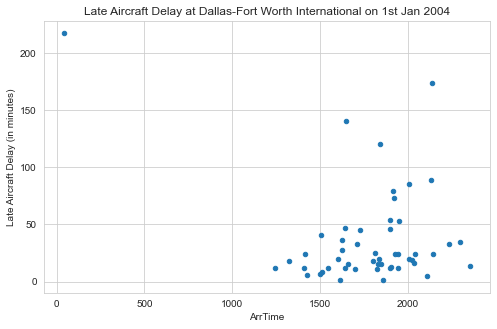

In [66]:
fig, ax = plt.subplots(figsize=(8, 5))

Airport_mostArrDelay_LateAircraftDelay.plot.scatter(x = 'ArrTime', y = 'LateAircraftDelay', ax = ax) 

ax.set_xlabel('ArrTime')
ax.set_ylabel('Late Aircraft Delay (in minutes)')

ax.title.set_text("Late Aircraft Delay at Dallas-Fort Worth International on 1st Jan 2004")

plt.savefig('Q4b.png') # you can find the file in the folder where you run this line of code

Extract the confirmed affected airports in the cascading failure from the airport that has the most arrival delays on the day itself.

In [67]:
# Extract data from database and saved as data frame
affectedairports = c.execute('''
SELECT Origin,Dest,OriAirport.airport,DestAirport.airport,
OriAirport.lat,OriAirport.long,DestAirport.lat,DestAirport.long,ArrDelay,DepDelay,
CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,DepTime,ArrTime,TailNum
FROM delays
INNER JOIN airports as OriAirport ON delays.Origin=OriAirport.iata
INNER JOIN airports as DestAirport ON delays.Dest=DestAirport.iata
WHERE delays.Year=2004 
AND delays.Month=1 
AND delays.DayofMonth=1 
AND LateAircraftDelay > 0
AND DepDelay > 0 
AND ArrDelay > 0
AND OriAirport.airport='Dallas-Fort Worth International'
''').fetchall() 

affectedairports = pd.DataFrame(affectedairports)
affectedairports

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,DFW,ORD,Dallas-Fort Worth International,Chicago O'Hare International,32.895951,-97.0372,41.979595,-87.904464,75,86,7,0,0,0,68,1611,1814,N952UA
1,DFW,IAH,Dallas-Fort Worth International,George Bush Intercontinental,32.895951,-97.0372,29.980472,-95.339722,50,44,12,0,6,0,32,1429,1542,N15973
2,DFW,SHV,Dallas-Fort Worth International,Shreveport Regional,32.895951,-97.0372,32.446627,-93.825598,17,34,0,0,0,0,17,1414,1500,N840AS
3,DFW,MSY,Dallas-Fort Worth International,New Orleans International,32.895951,-97.0372,29.993389,-90.258028,29,47,0,0,0,0,29,2037,2154,N709EV
4,DFW,LAS,Dallas-Fort Worth International,McCarran International,32.895951,-97.0372,36.080361,-115.152333,15,15,9,0,0,0,6,1655,1747,N802AW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,DFW,FLL,Dallas-Fort Worth International,Fort Lauderdale-Hollywood Int'l,32.895951,-97.0372,26.072583,-80.152750,31,29,21,0,2,0,8,1334,1720,N381DA
61,DFW,TPA,Dallas-Fort Worth International,Tampa International,32.895951,-97.0372,27.975472,-82.533250,18,17,11,0,1,0,6,2002,2324,N905DA
62,DFW,SEA,Dallas-Fort Worth International,Seattle-Tacoma Intl,32.895951,-97.0372,47.448982,-122.309313,26,8,6,0,18,0,2,948,1232,N905DA
63,DFW,SLC,Dallas-Fort Worth International,Salt Lake City Intl,32.895951,-97.0372,40.788388,-111.977773,95,81,70,0,14,0,11,1856,2102,N947WP


In [68]:
affectedairports.rename({0:"Origin",1:"Dest",2:"Origin_Airport",3:"Dest_Airport",4:"Origin_lat",
                   5:"Origin_long",6:"Dest_lat",7:"Dest_long",8:"ArrDelay",9:"DepDelay",
                   10:"CarrierDelay",11:"WeatherDelay",12:"NASDelay",13:"SecurityDelay",
                   14:"LateAircraftDelay",15:"DepTime",16:"ArrTime",17:"TailNum"},
                   axis=1, inplace=True) # axis=1 is to denote columns to be renamed.

affectedairports.sort_values(by=['DepTime'])

,Origin,Dest,Origin_Airport,Dest_Airport,Origin_lat,Origin_long,Dest_lat,Dest_long,ArrDelay,DepDelay,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,DepTime,ArrTime,TailNum
8,DFW,MEM,Dallas-Fort Worth International,Memphis International,32.895951,-97.0372,35.042417,-89.976667,21,18,0,0,3,0,18,914,1042,N635MQ
64,DFW,LAS,Dallas-Fort Worth International,McCarran International,32.895951,-97.0372,36.080361,-115.152333,42,12,0,0,30,0,12,947,1120,N914DN
62,DFW,SEA,Dallas-Fort Worth International,Seattle-Tacoma Intl,32.895951,-97.0372,47.448982,-122.309313,26,8,6,0,18,0,2,948,1232,N905DA
16,DFW,ABQ,Dallas-Fort Worth International,Albuquerque International,32.895951,-97.0372,35.040222,-106.609194,43,23,0,19,20,0,4,1005,1114,N509AA
18,DFW,SAT,Dallas-Fort Worth International,San Antonio International,32.895951,-97.0372,29.533694,-98.469778,16,20,0,13,0,0,3,1124,1225,N427AA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37,DFW,FAT,Dallas-Fort Worth International,Fresno Yosemite International,32.895951,-97.0372,36.776194,-119.718139,48,50,29,8,0,0,11,2118,2244,N540AA
11,DFW,SAN,Dallas-Fort Worth International,San Diego International-Lindbergh,32.895951,-97.0372,32.733556,-117.189657,46,61,16,11,0,0,19,2127,2216,N583AA
54,DFW,ORD,Dallas-Fort Worth International,Chicago O'Hare International,32.895951,-97.0372,41.979595,-87.904464,40,50,0,14,0,0,26,2150,2349,N4WPAA
13,DFW,OKC,Dallas-Fort Worth International,Will Rogers World,32.895951,-97.0372,35.393088,-97.600734,137,147,81,14,0,0,42,2157,2246,N285AA


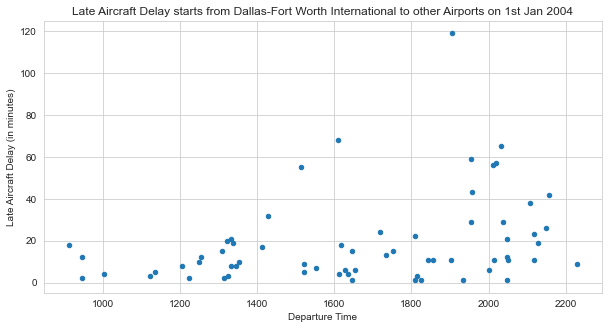

In [69]:
fig, ax = plt.subplots(figsize=(10, 5))

affectedairports.plot.scatter(x = 'DepTime', y = 'LateAircraftDelay', ax = ax) 

ax.set_xlabel('Departure Time')
ax.set_ylabel('Late Aircraft Delay (in minutes)')

ax.title.set_text("Late Aircraft Delay starts from Dallas-Fort Worth International to other Airports on 1st Jan 2004")

plt.savefig('Q4c.png') # you can find the file in the folder where you run this line of code

Data Preparation for second busy airport for the cascading failure from the most busy airport on 1st Jan 2004

In [70]:
MostAffectedAirport = affectedairports.groupby(['Dest_Airport'])[['DepTime']].count()
MostAffectedAirport.columns = ['Value_counts']
MostAffectedAirport.sort_values(by=['Value_counts'], ascending=False, inplace=True)
MostAffectedAirport.head()

,Value_counts
Dest_Airport,
Chicago O'Hare International,3
New Orleans International,3
Tampa International,3
McCarran International,3
San Antonio International,3


In [71]:
affectedairports_list = list(affectedairports['Dest_Airport'])  
affectedairports_list

["Chicago O'Hare International",
 'George Bush Intercontinental',
 'Shreveport Regional',
 'New Orleans International ',
 'McCarran International',
 'Amarillo International',
 'Cleveland-Hopkins Intl',
 'Northwest Arkansas Regional',
 'Memphis International',
 'Miami International',
 'San Jose International',
 'San Diego International-Lindbergh ',
 'San Jose International',
 'Will Rogers World',
 'San Antonio International',
 'Tampa International ',
 'Albuquerque International',
 'Fresno Yosemite International',
 'San Antonio International',
 'San Diego International-Lindbergh ',
 'Phoenix Sky Harbor International',
 'Palm Springs International',
 'Reno/Tahoe International',
 'Salt Lake City Intl',
 'Tampa International ',
 'Detroit Metropolitan-Wayne County',
 'Reno/Tahoe International',
 'Portland Intl',
 'Ronald Reagan Washington National',
 'Long Beach (Daugherty )',
 'Seattle-Tacoma Intl',
 'Tucson International',
 'Will Rogers World',
 'Memphis International',
 "Fort Lauderdale-H

Additional Step (Optional): Check the affected airport with arrival time

In [84]:
check = delays_df4[delays_df4['Origin_Airport'].isin(["Dallas-Fort Worth International"])]
check = check[check['Dest_Airport'].isin(["Chicago O'Hare International"])]
check = check[check['LateAircraftDelay']>0]
check.iloc[:,[0,1,2,3,8,9,10,11,14,15,16,17]]

,Origin,Dest,Origin_Airport,Dest_Airport,ArrDelay,DepDelay,CarrierDelay,WeatherDelay,LateAircraftDelay,DepTime,ArrTime,TailNum
352,DFW,ORD,Dallas-Fort Worth International,Chicago O'Hare International,75,86,7,0,68,1611,1814,N952UA
4602,DFW,ORD,Dallas-Fort Worth International,Chicago O'Hare International,53,68,0,15,38,2108,2306,N519AA
4604,DFW,ORD,Dallas-Fort Worth International,Chicago O'Hare International,40,50,0,14,26,2150,2349,N4WPAA


N952UA appears in the next delay propagation.

I can detect cascading delays. This is one of the simple examples and illustrations of a cascading failure (delay) based on my assumption I have made on this question. There undoubtedly will be other cascading delays in a big picture

In [85]:
affectedLateAircraft_fromMostArrDelayAirport = list(check['TailNum'])
cascading = delays_df4[delays_df4['Origin_Airport'].isin(["Chicago O'Hare International"])]
cascading = cascading[cascading['TailNum'].isin(affectedLateAircraft_fromMostArrDelayAirport)]
cascading.iloc[:,[0,1,2,3,8,9,10,11,14,15,16,17]]

,Origin,Dest,Origin_Airport,Dest_Airport,ArrDelay,DepDelay,CarrierDelay,WeatherDelay,LateAircraftDelay,DepTime,ArrTime,TailNum
353,ORD,PHL,Chicago O'Hare International,Philadelphia Intl,49,51,7,0,42,1851,2156,N952UA
371,ORD,DFW,Chicago O'Hare International,Dallas-Fort Worth International,168,168,168,0,0,1303,1533,N952UA


The reason I used `TailNum` is to ensure that it was the delay propagation or cascading failure caused by the previous delays rather than it was caused by other delays such as security delay in that specific airport or flight.

So I did not show the second most busy airport where contains the second most delays. This is because the delays can be caused by other reasons and not the previous delay. This is to ensure that I can clearly show the delay propagation using `networx` library.

In [74]:
#row-bind two DataFrames and reset index values
df_g = pd.concat([affectedairports,cascading]).reset_index(drop=True)
df_g

,Origin,Dest,Origin_Airport,Dest_Airport,Origin_lat,Origin_long,Dest_lat,Dest_long,ArrDelay,DepDelay,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,DepTime,ArrTime,TailNum
0,DFW,ORD,Dallas-Fort Worth International,Chicago O'Hare International,32.895951,-97.037200,41.979595,-87.904464,75,86,7,0,0,0,68,1611,1814,N952UA
1,DFW,IAH,Dallas-Fort Worth International,George Bush Intercontinental,32.895951,-97.037200,29.980472,-95.339722,50,44,12,0,6,0,32,1429,1542,N15973
2,DFW,SHV,Dallas-Fort Worth International,Shreveport Regional,32.895951,-97.037200,32.446627,-93.825598,17,34,0,0,0,0,17,1414,1500,N840AS
3,DFW,MSY,Dallas-Fort Worth International,New Orleans International,32.895951,-97.037200,29.993389,-90.258028,29,47,0,0,0,0,29,2037,2154,N709EV
4,DFW,LAS,Dallas-Fort Worth International,McCarran International,32.895951,-97.037200,36.080361,-115.152333,15,15,9,0,0,0,6,1655,1747,N802AW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,DFW,SEA,Dallas-Fort Worth International,Seattle-Tacoma Intl,32.895951,-97.037200,47.448982,-122.309313,26,8,6,0,18,0,2,948,1232,N905DA
63,DFW,SLC,Dallas-Fort Worth International,Salt Lake City Intl,32.895951,-97.037200,40.788388,-111.977773,95,81,70,0,14,0,11,1856,2102,N947WP
64,DFW,LAS,Dallas-Fort Worth International,McCarran International,32.895951,-97.037200,36.080361,-115.152333,42,12,0,0,30,0,12,947,1120,N914DN
65,ORD,PHL,Chicago O'Hare International,Philadelphia Intl,41.979595,-87.904464,39.871953,-75.241141,49,51,7,0,0,0,42,1851,2156,N952UA


In [75]:
edges = df_g[['Origin', 'Dest']].values
g = nx.from_edgelist(edges)
len(g.nodes()), len(g.edges())

(42, 42)

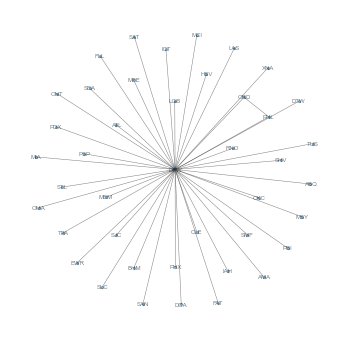

In [76]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
nx.draw_networkx(g, ax=ax, node_size=5,
                 font_size=6, alpha=.5,
                 width=.5)
ax.set_axis_off()

In [77]:
sg = next(g.subgraph(c) for c in nx.connected_components(g))

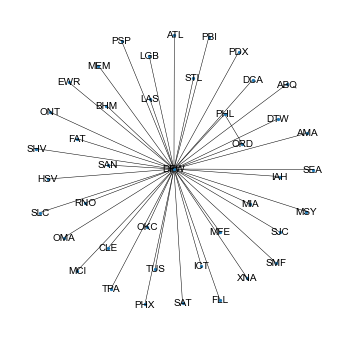

In [78]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
nx.draw_networkx(sg, ax=ax, with_labels=True,
                 node_size=5, font_size=10, width=.5)
ax.set_axis_off()

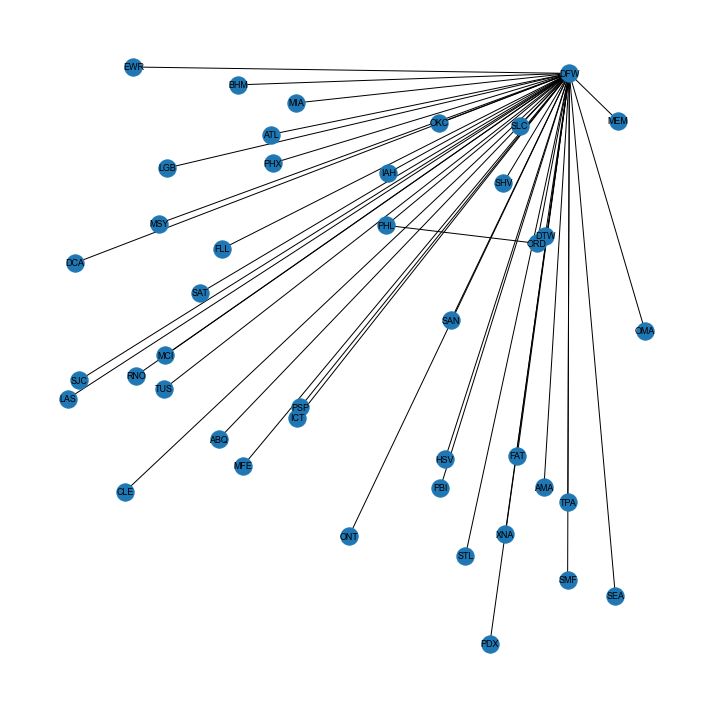

In [79]:
plt.subplots(figsize=(10,10))
pos=nx.random_layout(sg)
nx.draw(sg,pos=pos,font_size=9)
nx.draw_networkx_labels(sg,pos=pos,font_size=9)
plt.tight_layout()
plt.axis('off');
plt.show()

Here we can clearly see that firstly arrival delays in one airport that some also caused by late aircraft delays creates delays in others. In other words, it secondly creates delays in other airports. This can be clearly see as the nodes below. Next, it then caused another same aircraft delay to further airport. In a nutshell, I can detect cascading failures (delays) as delays in one airport creates delays in others.

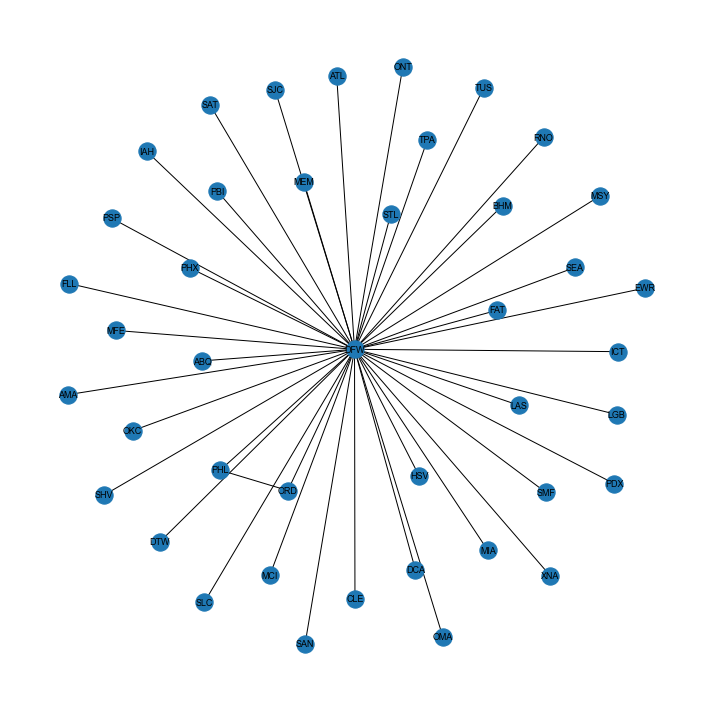

In [80]:
plt.subplots(figsize=(10,10))
pos=nx.spring_layout(sg)
nx.draw(sg,pos=pos,font_size=9)
nx.draw_networkx_labels(sg,pos=pos,font_size=9)
plt.tight_layout()
plt.axis('off');

plt.savefig('Q4d.png') # you can find the file in the folder where you run this line of code

# Q5. Use the available variables to construct a model that predicts delays.
# Flight Arrival Delays Prediction using Machine Learning Classification Algorithms
Given the available variables, predict if a flight will have arrival delay.

### Data Extraction from SQLite Database

In [14]:
# Extract data from database and saved as data frame
# Required some time to extract! Once extracted this, the following code chunks should be run quite fast
delays_df5 = c.execute('''
SELECT CRSDepTime,CRSArrTime,CRSElapsedTime,OriAirport.airport,DestAirport.airport,ArrDelay
FROM delays
INNER JOIN airports as OriAirport ON delays.Origin=OriAirport.iata
INNER JOIN airports as DestAirport ON delays.Dest=DestAirport.iata
''').fetchall() 

# ORDER BY RANDOM() LIMIT 400 #Select a random rows with sqlite, however, cannot set seed to ensure reproducibility

delays_df5 = pd.DataFrame(delays_df5)
delays_df5

,0,1,2,3,4,5
0,630,915,105.0,Chicago O'Hare International,Charlotte/Douglas International,-14.0
1,630,915,105.0,Chicago O'Hare International,Charlotte/Douglas International,-4.0
2,630,915,105.0,Chicago O'Hare International,Charlotte/Douglas International,5.0
3,630,915,105.0,Chicago O'Hare International,Charlotte/Douglas International,-16.0
4,630,915,105.0,Chicago O'Hare International,Charlotte/Douglas International,3.0
...,...,...,...,...,...,...
21411782,1249,1459,130.0,William B Hartsfield-Atlanta Intl,Newark Intl,-7.0
21411783,1155,1931,276.0,Seattle-Tacoma Intl,William B Hartsfield-Atlanta Intl,62.0
21411784,2115,2241,86.0,William B Hartsfield-Atlanta Intl,Orlando International,13.0
21411785,2127,2223,116.0,Salt Lake City Intl,San Jose International,-14.0


### Data Preparation for Machine Learning Pipeline

In [15]:
# Extract sub samples for Machine Learning train and test
# With a given seed, the sample will always draw the same rows
df5 = delays_df5.sample(n = 2200, replace = False, random_state = 7000)

In [16]:
df5.rename({0:"CRSDepTime",1:"CRSArrTime",2:"CRSElapsedTime",3:"Origin_Airport",4:"Dest_Airport",5:"ArrDelay"},
           axis=1, inplace=True) # axis=1 is to denote columns to be renamed.
df5.head()

,CRSDepTime,CRSArrTime,CRSElapsedTime,Origin_Airport,Dest_Airport,ArrDelay
16968267,823,915,52.0,University of Illinois-Willard,Chicago O'Hare International,10.0
5942109,1415,1731,136.0,Sacramento International,Denver Intl,9.0
3145928,910,1200,110.0,Chicago O'Hare International,Roanoke Regional/ Woodrum,14.0
10429189,826,1100,94.0,Phoenix Sky Harbor International,Salt Lake City Intl,55.0
2010948,2215,530,255.0,Los Angeles International,St. Petersburg-Clearwater International,2.0


In [17]:
# Adding the Arrival_Delay column as category 1 = Delayed, 0 = No delayed
df5['Arrival_Delay'] = df5['ArrDelay'].apply(lambda x: 1 if x>0 else 0)

df5.drop(['ArrDelay'], axis=1, inplace=True)
df5

,CRSDepTime,CRSArrTime,CRSElapsedTime,Origin_Airport,Dest_Airport,Arrival_Delay
16968267,823,915,52.0,University of Illinois-Willard,Chicago O'Hare International,1
5942109,1415,1731,136.0,Sacramento International,Denver Intl,1
3145928,910,1200,110.0,Chicago O'Hare International,Roanoke Regional/ Woodrum,1
10429189,826,1100,94.0,Phoenix Sky Harbor International,Salt Lake City Intl,1
2010948,2215,530,255.0,Los Angeles International,St. Petersburg-Clearwater International,1
...,...,...,...,...,...,...
13486542,1750,130,280.0,McCarran International,John F Kennedy Intl,1
20006447,1135,1125,50.0,Kent County International,Chicago O'Hare International,0
12869200,1330,1411,41.0,Cincinnati Northern Kentucky Intl,James M Cox Dayton Intl,1
10251856,1331,1607,156.0,Minneapolis-St Paul Intl,New Orleans International,1


In [18]:
print(df5.shape)
df5.info()

(2200, 6)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2200 entries, 16968267 to 2560109
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CRSDepTime      2200 non-null   int64  
 1   CRSArrTime      2200 non-null   int64  
 2   CRSElapsedTime  2200 non-null   float64
 3   Origin_Airport  2200 non-null   object 
 4   Dest_Airport    2200 non-null   object 
 5   Arrival_Delay   2200 non-null   int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 120.3+ KB


In [19]:
# Set features
x = df5.iloc[:,:-1]

# Set targets / labels
y = df5[['Arrival_Delay']]
x

,CRSDepTime,CRSArrTime,CRSElapsedTime,Origin_Airport,Dest_Airport
16968267,823,915,52.0,University of Illinois-Willard,Chicago O'Hare International
5942109,1415,1731,136.0,Sacramento International,Denver Intl
3145928,910,1200,110.0,Chicago O'Hare International,Roanoke Regional/ Woodrum
10429189,826,1100,94.0,Phoenix Sky Harbor International,Salt Lake City Intl
2010948,2215,530,255.0,Los Angeles International,St. Petersburg-Clearwater International
...,...,...,...,...,...
13486542,1750,130,280.0,McCarran International,John F Kennedy Intl
20006447,1135,1125,50.0,Kent County International,Chicago O'Hare International
12869200,1330,1411,41.0,Cincinnati Northern Kentucky Intl,James M Cox Dayton Intl
10251856,1331,1607,156.0,Minneapolis-St Paul Intl,New Orleans International


### Pipelines: Pre-Processing Stage

In [20]:
numerical_features = ['CRSDepTime','CRSArrTime','CRSElapsedTime'] 

# Applying SimpleImputer and StandardScaler into a pipeline
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler())])

In [21]:
categorical_features = ['Origin_Airport','Dest_Airport']

# Applying SimpleImputer and then OneHotEncoder into another pipeline
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [22]:
data_transformer = ColumnTransformer(
    transformers=[
        ('numerical', numerical_transformer, numerical_features),
        ('categorical', categorical_transformer, categorical_features)]) 

### Setup train test set (Split Samples)

In [23]:
X_train, X_test, y_Arr_train, y_Arr_test = train_test_split(x, y, test_size=0.4, random_state=1)

In [24]:
# Note: Parameters of pipelines are set using '__' separated parameter names
param_grid = {
    'data_transformer__numerical__imputer__strategy': ['mean', 'median'],
    'data_transformer__categorical__imputer__strategy': ['constant','most_frequent']
}

## Train Machine Learning Models

### Pipelines With Logistic Regression

In [25]:
pipe_lr = Pipeline(steps=[('data_transformer', data_transformer),
                      ('pipe_lr', LogisticRegression(max_iter=10000, penalty='none'))])
grid_lr = GridSearchCV(pipe_lr, param_grid=param_grid, cv = 10, n_jobs = -1)  #default cv is 5-fold
grid_lr.fit(X_train, y_Arr_train.values.ravel());

#.values will give the values in a numpy array (shape: (n,1))
#.ravel will convert that array shape to (n, ) (i.e. flatten it)

### Pipelines With Penalised Logistic Regression

In [26]:
# Penalised logistic regression
pipe_plr = Pipeline(steps=[('data_transformer', data_transformer),
                           ('pipe_plr', LogisticRegression(penalty='l1', max_iter=10000, tol=0.01, solver='saga'))])
grid_plr = GridSearchCV(pipe_plr, param_grid=param_grid, cv = 10, n_jobs = -1)
grid_plr.fit(X_train, y_Arr_train.values.ravel());

# tol=0.01 -- tolerance for stopping criteria; stop searching for a minimum (or maximum) once some tolerance is achieved
# solver='saga' -- algorithm to use in the optimization problem; 'sag' and 'saga' are faster for large datasets

### Pipelines With Gradient Boosting

In [27]:
pipe_gdb = Pipeline(steps=[('data_transformer', data_transformer),
                           ('pipe_gdb', GradientBoostingClassifier(random_state=2))])

grid_gdb = GridSearchCV(pipe_gdb, param_grid=param_grid, cv = 10, n_jobs = -1)  
grid_gdb.fit(X_train, y_Arr_train.values.ravel());

### Pipelines With Classification tree

In [28]:
# Classification tree
pipe_tree = Pipeline(steps=[('data_transformer', data_transformer),
                           ('pipe_tree', DecisionTreeClassifier(random_state=0))])
grid_tree = GridSearchCV(pipe_tree, param_grid=param_grid, cv = 10, n_jobs = -1)
grid_tree.fit(X_train, y_Arr_train);

### Pipelines With Random forest

In [29]:
# Random forest
pipe_rf = Pipeline(steps=[('data_transformer', data_transformer),
                           ('pipe_rf', RandomForestClassifier(random_state=33))])
grid_rf = GridSearchCV(pipe_rf, param_grid=param_grid, cv = 10, n_jobs = -1)
grid_rf.fit(X_train, y_Arr_train.values.ravel());
#max_depth = 5, n_estimators=100,

### Pipelines With Support Vector Machines

In [30]:
# Support vector machines
pipe_svm = Pipeline(steps=[('data_transformer', data_transformer),
                           ('pipe_svm',  LinearSVC(random_state=0, max_iter=10000, tol=0.01))])
grid_svm = GridSearchCV(pipe_svm, param_grid=param_grid, cv = 10, n_jobs = -1)
grid_svm.fit(X_train, y_Arr_train.values.ravel());

In [31]:
# Support vector machines (with additional hyperparameter tuning)
# Note: LinearSVC generates a linear classifier, while SVC lets you choose non-linear kernels

pipe_svc = Pipeline(steps=[('data_transformer', data_transformer),
                           ('pipe_svc',  SVC(probability=True))])

# Hyperparameter tuning
param_grid2 = param_grid.copy()  #copy and extend param_grid
param_grid2['pipe_svc__kernel']=['rbf', 'poly','sigmoid']
param_grid2['pipe_svc__C']=[0.1, 1, 10]

#Alternatively, you can use '**' to pass multiple arguments to a function directly using a dictionary
#param_grid2 = { **param_grid,
#               'pipe_svc__kernel':['rbf', 'poly','sigmoid'],
#               'pipe_svc__C':[0.1, 1, 10]
#              }
                        
grid_svc = GridSearchCV(pipe_svc, param_grid=param_grid2, cv = 10, n_jobs = -1)
grid_svc.fit(X_train, y_Arr_train.values.ravel());

grid_svc.best_params_
#grid_svc.best_estimator_
#grid_svc.best_score_

{'data_transformer__categorical__imputer__strategy': 'constant',
 'data_transformer__numerical__imputer__strategy': 'mean',
 'pipe_svc__C': 0.1,
 'pipe_svc__kernel': 'sigmoid'}

### Pipelines With k-Nearest Neighbors

In [32]:
pipe_knn = Pipeline(steps=[('data_transformer', data_transformer),
                           ('pipe_knn', KNeighborsClassifier(n_neighbors=5))])

grid_knn = GridSearchCV(pipe_knn, param_grid=param_grid, cv = 10, n_jobs = -1) 
grid_knn.fit(X_train, y_Arr_train.values.ravel());

## Evaluation - Compare performance of classification models by the ROC curve

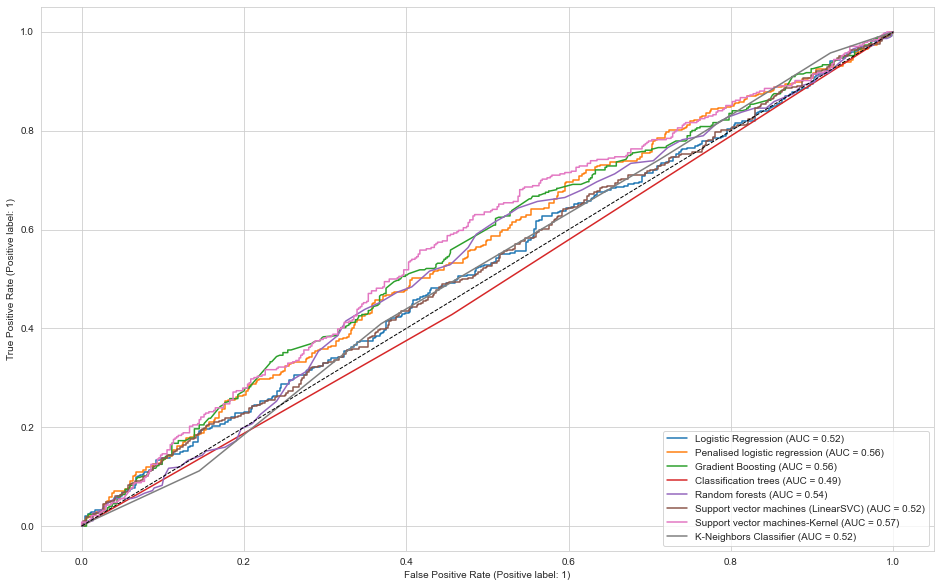

In [37]:
ax, fig = plt.subplots(figsize=(16,10))
ax = plt.gca()  # get current Axes instance

plot_roc_curve(grid_lr, X_test, y_Arr_test, ax=ax, name='Logistic Regression')
plot_roc_curve(grid_plr, X_test, y_Arr_test, ax=ax, name='Penalised logistic regression')
plot_roc_curve(grid_gdb, X_test, y_Arr_test, ax=ax, name='Gradient Boosting')
plot_roc_curve(grid_tree, X_test, y_Arr_test, ax=ax, name='Classification trees')
plot_roc_curve(grid_rf, X_test, y_Arr_test, ax=ax, name='Random forests')
plot_roc_curve(grid_svm, X_test, y_Arr_test, ax=ax, name='Support vector machines (LinearSVC)')
plot_roc_curve(grid_svc, X_test, y_Arr_test, ax=ax, name='Support vector machines-Kernel')
plot_roc_curve(grid_knn, X_test, y_Arr_test, ax=ax, name='K-Neighbors Classifier')

plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')

plt.savefig('Q5a.png') # you can find the file in the folder where you run this line of code

https://www.statology.org/what-is-a-good-auc-score/

The support vector machine (SVM) works best when data has exactly two classes in this case. The SVM classifies data by finding the best hyperplane that separates all data points of one class from those of the other class. The real advantages of SVM comes from its accuracy and the fact that it tends not to overfit the data.

## Confusion Matrix (using Support Vector Machines - Kernel)

##### Best parameter in 'pipe_svc__kernel' is 'sigmoid'

In [51]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve, precision_recall_curve

y_Arr_pred = grid_svc.predict(X_test)

[0 1]
[[489  15]
 [364  12]]


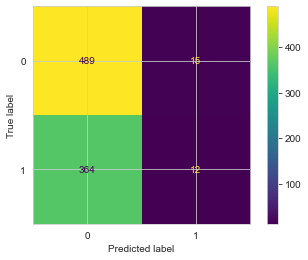

In [52]:
# Generate and display confusion matrix
cm = confusion_matrix(y_Arr_test, y_Arr_pred, labels=grid_svc.classes_)  #generate confusion matrix
print(grid_svc.classes_)
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.savefig('Q5c.png') # you can find the file in the folder where you run this line of code

In [53]:
# Show classification report
print(classification_report(y_Arr_test, y_Arr_pred))

# Show classification metrics
print('accuracy score: ', accuracy_score(y_Arr_test, y_Arr_pred))
print('recall score: ', recall_score(y_Arr_test, y_Arr_pred, average=None))
print('precision score: ', precision_score(y_Arr_test, y_Arr_pred, average=None))
print('f1 score: ', f1_score(y_Arr_test, y_Arr_pred, average=None))

              precision    recall  f1-score   support

           0       0.57      0.97      0.72       504
           1       0.44      0.03      0.06       376

    accuracy                           0.57       880
   macro avg       0.51      0.50      0.39       880
weighted avg       0.52      0.57      0.44       880

accuracy score:  0.5693181818181818
recall score:  [0.9702381  0.03191489]
precision score:  [0.57327081 0.44444444]
f1 score:  [0.72070744 0.05955335]


In [59]:
# Generate confusion matrix with different threshold (default is 0.5)
y_Arr_pred = (grid_svc.predict_proba(X_test)[:,1] >= 0.5).astype(int) #set threshold of 0.5

# Show classification report
print(classification_report(y_Arr_test, y_Arr_pred))

# Show classification metrics
print('accuracy score: ', accuracy_score(y_Arr_test, y_Arr_pred))
print('recall score: ', recall_score(y_Arr_test, y_Arr_pred, average=None))
print('precision score: ', precision_score(y_Arr_test, y_Arr_pred, average=None))
print('f1 score: ', f1_score(y_Arr_test, y_Arr_pred, average=None))

              precision    recall  f1-score   support

           0       0.58      0.94      0.71       504
           1       0.48      0.08      0.13       376

    accuracy                           0.57       880
   macro avg       0.53      0.51      0.42       880
weighted avg       0.54      0.57      0.47       880

accuracy score:  0.5704545454545454
recall score:  [0.93849206 0.07712766]
precision score:  [0.57682927 0.48333333]
f1 score:  [0.71450151 0.13302752]


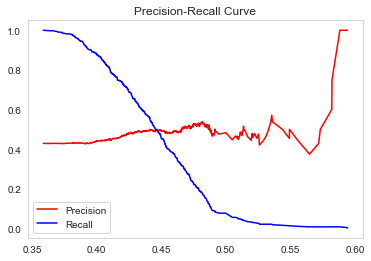

In [55]:
# Plot Precision-Recall Curve (helps to manually select a threshold to use if necessary)

precision, recall, threshold = precision_recall_curve(y_Arr_test.astype(int), 
                                                      grid_svc.predict_proba(X_test)[:,1])

plt.plot(threshold, precision[:-1], c ='r', label ='Precision')
plt.plot(threshold, recall[:-1], c ='b', label ='Recall')
plt.grid()
plt.legend()
plt.title('Precision-Recall Curve')
plt.savefig('Q5d.png') # you can find the file in the folder where you run this line of code

The precision-recall curve shows the tradeoff between precision and recall for different threshold. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate.

### Permutation Based Feature Importance (with scikit-learn) for Random Forest

In [56]:
#https://towardsdatascience.com/explaining-feature-importance-by-example-of-a-random-forest-d9166011959e
from sklearn.metrics import r2_score
#pip install rfpimp
from rfpimp import permutation_importances

def r2(rf, X_train, y_Arr_train):
    return r2_score(y_Arr_train, grid_rf.predict(X_train))

perm_imp_rfpimp = permutation_importances(grid_rf, X_train, y_Arr_train.values.ravel(), r2)
#perm_imp_rfpimp.sort_values('Importances',inplace=True)
perm_imp_rfpimp

,Importance
Feature,
Origin_Airport,0.750701
Dest_Airport,0.575332
CRSArrTime,0.375350
CRSElapsedTime,0.344584
CRSDepTime,0.338431


<Figure size 480x480 with 0 Axes>

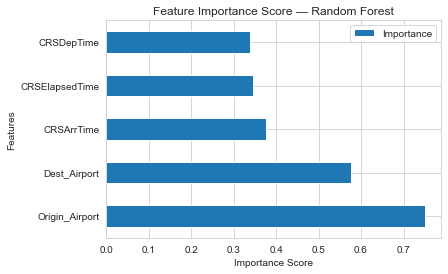

In [57]:
plt.figure(num=None, figsize=(6, 6), dpi=80, facecolor='w', edgecolor='k');
perm_imp_rfpimp.plot(kind='barh')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Feature Importance Score — Random Forest')
plt.savefig('Q5b.png') # you can find the file in the folder where you run this line of code

In [10]:
conn.close()